In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

xarray: 0.12.1, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


## Create a model

First, let's import a Profile Classification Model (PCM) constructor:

In [2]:
from pyxpcm.pcmodel import pcm

In [3]:
# Define a vertical axis and features to use:
z = np.arange(0.,-1000,-10.)
pcm_features = {'temperature': z, 'salinity':z}

# Instantiate a PCM:
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>

In [4]:
import pyxpcm
ds = pyxpcm.tutorial.open_dataset('argo').load()
print(ds)

<xarray.Dataset>
Dimensions:    (DEPTH: 282, N_PROF: 7560)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: N_PROF
Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
Attributes:
    Sample test prepared by:  G. Maze
    Institution:              Ifremer/LOPS
    Data source D

## Fit model parameters

Fitting can be done on any dataset coherent with the PCM definition, in a sense that it should have the feature variables available. To tell the PCM model how to identify features in the dataset, we simply provide a dictionary mapping of variable names:

In [5]:
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

which means that the PCM feature ``temperature`` is to be found in the dataset variables ``TEMP``. Now we can simply fit the model on the this dataset like:

In [19]:
# Fit:
m.fit(ds, features=features_in_ds)
# or:
# ds.pyxpcm.fit(m, features=features_in_ds)

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 37.953148

In [23]:
# ds.pyxpcm.fit(m, features=features_in_ds, dim='DEPTH')
m.fit(ds, features=features_in_ds, dim='DEPTH')

<pcm 'gmm' (K: 8, F: 2)>
Number of class: 8
Number of feature: 2
Feature names: odict_keys(['temperature', 'salinity'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Feature: 'salinity'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing.data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition.pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture.gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 38.822988

## Prediction of labels

Now that the PCM is fitted, we can predict the classification results like:

In [24]:
ds.pyxpcm.predict(m, features=features_in_ds, inplace=True)
#or:  ds = m.predict(ds, features=features_in_ds, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DE

Prediction labels are automatically added to the dataset as ``PCM_LABELS`` (because the option ``inplace`` was set to ``True``). 

Since we used a GMM classifier by default, we also can predict the probability of each classes for all profiles, the so-called *posteriors*:

In [25]:
ds = ds.pyxpcm.predict_proba(m, features=features_in_ds, inplace=True)
#or: ds = m.predict_proba(ds, features=features_in_ds, inplace=True)
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DE

In [22]:
print("Before cleaning", ds.data_vars)
# print("Before cleaning", ds.pyxpcm._obj.data_vars)
ds_after = ds.pyxpcm.clean() 
# print("\nAfter cleaning", ds.data_vars)
# print("After cleaning", ds.pyxpcm._obj.data_vars)
print("\nAfter cleaning", ds_after.data_vars)

Before cleaning Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>

After cleaning Data variables:
    LATITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX    

It is important to note that once the PCM is fitted, you can predict labels for any dataset, as long as it has the PCM features.

For instance, let's predict labels for a gridded dataset based on the previous Argo-based model:

In [11]:
ds_gridded = pyxpcm.tutorial.open_dataset('isas_snapshot').load()
print(ds_gridded)

<xarray.Dataset>
Dimensions:      (depth: 152, latitude: 53, longitude: 61)
Coordinates:
  * latitude     (latitude) float32 30.023445 30.455408 ... 49.41288 49.737103
  * longitude    (longitude) float32 -70.0 -69.5 -69.0 ... -41.0 -40.5 -40.0
  * depth        (depth) float32 -1.0 -3.0 -5.0 ... -1960.0 -1980.0 -2000.0
Data variables:
    TEMP         (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    TEMP_ERR     (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    TEMP_PCTVAR  (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL         (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL_ERR     (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61)>
    PSAL_PCTVAR  (depth, latitude, longitude) float32 dask.array<shape=(152, 53, 61), chunksize=(152, 53, 61

In [32]:
labels = ds_gridded.pyxpcm.predict(m, features={'temperature':'TEMP','salinity':'PSAL'}, dim='depth', inplace=False)
# ds_gridded = ds_gridded.pyxpcm.predict(m, features={'temperature':'TEMP','salinity':'PSAL'}, dim='depth', inplace=True)
# ds_gridded = m.predict(ds_gridded, features={'temperature':'TEMP','salinity':'PSAL'}, dim='depth', inplace=True)
# ds_gridded

## Example of label visualisation

To follow this section you’ll need to have Cartopy installed and working.  
A map of labels can now easily be plotted:

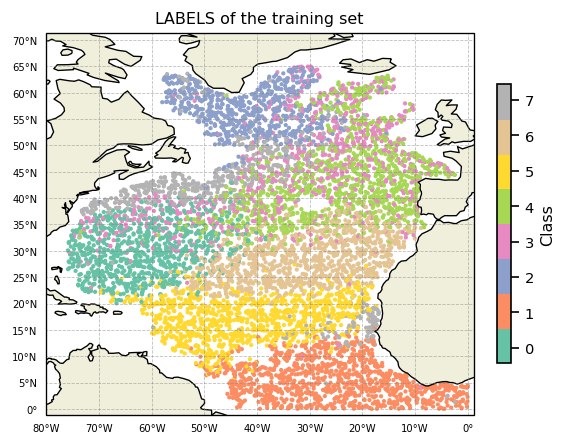

In [13]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set')
plt.show()

Since we predict labels for 2 datasets, we can superimpose them

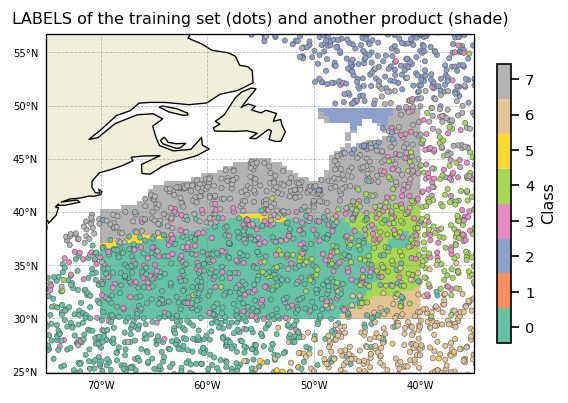

In [14]:
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-75,-35,25,55]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

kmap = m.plot.cmap()
sc = ax.pcolor(ds_gridded['longitude'], ds_gridded['latitude'], ds_gridded['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K)
sc = ax.scatter(ds['LONGITUDE'], ds['LATITUDE'], s=10, c=ds['PCM_LABELS'], cmap=kmap, transform=proj, vmin=0, vmax=m.K, edgecolors=[0.3]*3, linewidths=0.3)
cl = m.plot.colorbar(ax=ax)

gl = m.plot.latlongrid(ax, dx=10)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('LABELS of the training set (dots) and another product (shade)')
plt.show()

*Posteriors* are defined for each data point and give the probability of that point to belong to any of the classes. It can be plotted this way:

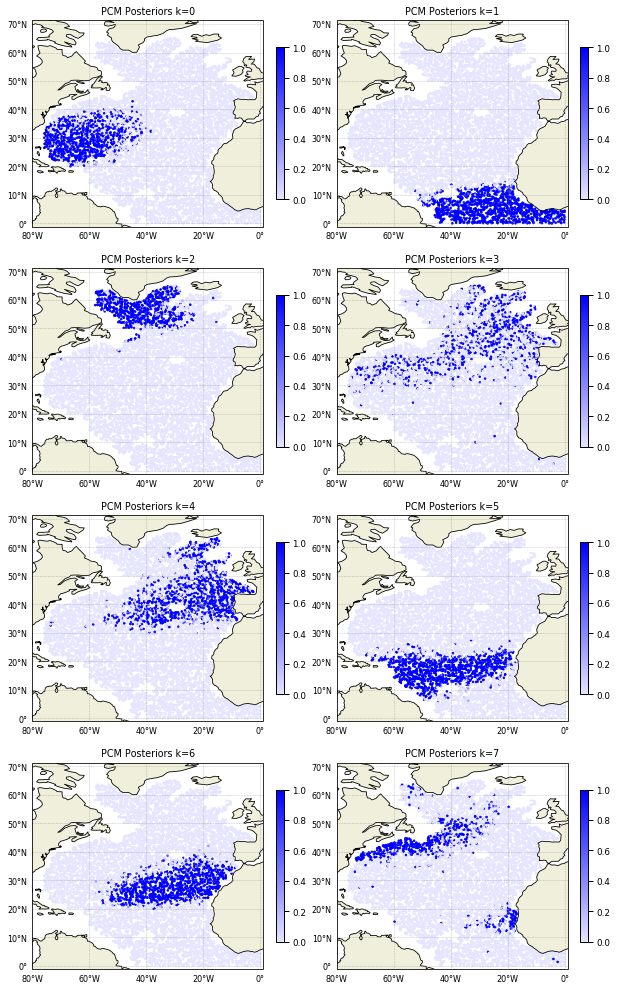

In [15]:
cmap = sns.light_palette("blue", as_cmap=True)
proj = ccrs.PlateCarree()
subplot_kw={'projection': proj, 'extent': np.array([-80,1,-1,66]) + np.array([-0.1,+0.1,-0.1,+0.1])}
fig, ax = m.plot.subplots(figsize=(10,22), maxcols=2, subplot_kw=subplot_kw)

for k in m:
    sc = ax[k].scatter(ds['LONGITUDE'], ds['LATITUDE'], s=3, c=ds['PCM_POST'].sel(pcm_class=k), 
                       cmap=cmap, transform=proj, vmin=0, vmax=1)
    cl = plt.colorbar(sc, ax=ax[k], fraction=0.03)
    gl = m.plot.latlongrid(ax[k], fontsize=8, dx=20, dy=10)
    ax[k].add_feature(cfeature.LAND)
    ax[k].add_feature(cfeature.COASTLINE)
    ax[k].set_title('PCM Posteriors k=%i' % k)

In [16]:
# ds = ds.pyxpcm.clean()
# m.stat
ds

<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8)
Coordinates:
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
Dimensions without coordinates: pcm_class
Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    

In [17]:
for vname in ['TEMP', 'PSAL']:
#     da = m.stat.quantile(ds, [0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True)
#     ds = xr.merge([ds,da])
    ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=vname, outname=vname + '_Q', keep_attrs=True, inplace=True)

print(ds)

/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/stats.py:54: UserWarning: quantile does not work for arrays stored as dask arrays. Loading array data via .load() 
  warnings.warn("quantile does not work for arrays stored as dask arrays. Loading array data via .load() ")
/Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/stats.py:54: UserWarning: quantile does not work for arrays stored as dask arrays. Loading array data via .load() 
  warnings.warn("quantile does not work for arrays stored as dask arrays. Loading array data via .load() ")


<xarray.Dataset>
Dimensions:     (DEPTH: 282, N_PROF: 7560, pcm_class: 8, quantile: 3)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * N_PROF      (N_PROF) int64 0 1 2 3 4 5 6 ... 7554 7555 7556 7557 7558 7559
  * DEPTH       (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1395.0 -1400.0 -1405.0
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    LATITUDE    (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    LONGITUDE   (N_PROF) float32 dask.array<shape=(7560,), chunksize=(7560,)>
    TIME        (N_PROF) datetime64[ns] dask.array<shape=(7560,), chunksize=(7560,)>
    DBINDEX     (N_PROF) float64 dask.array<shape=(7560,), chunksize=(7560,)>
    TEMP        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    PSAL        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    SIG0        (N_PROF, DEPTH) float32 dask.array<shape=(7560, 282), chunksize=(7560, 282)>
    BRV2        (N_PROF, DE

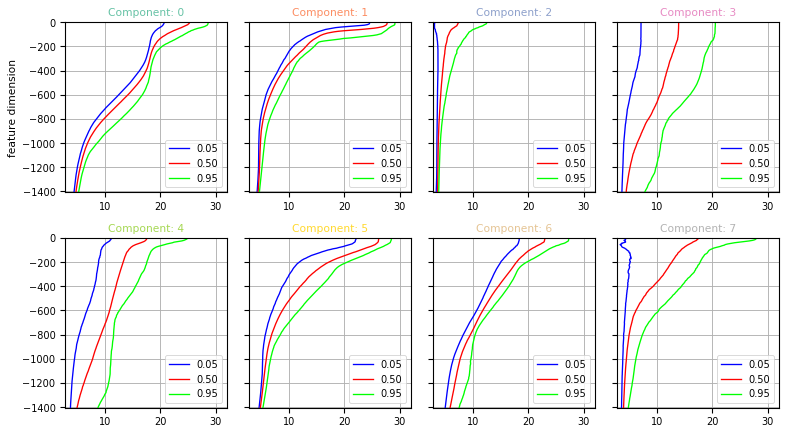

In [18]:
fig, ax = m.plot.quantile(ds['TEMP_Q'], maxcols=4, figsize=(10, 8), sharey=True)